In [1]:
import os
import warnings

import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
import matplotlib.pyplot as plt
import cv2

from train import create_net
from utils.eval import eval_net

warnings.filterwarnings("ignore")
np.random.seed(63910)
torch.manual_seed(53152)
torch.cuda.manual_seed_all(7987)
torch.backends.cudnn.deterministic = True

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [3]:
transform = T.Compose([
    T.Resize(51), # 缩放图片(Image)，保持长宽比不变，最短边为img_size像素
    T.CenterCrop(51), # 从图片中间切出img_size*img_size的图片
    T.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
    #T.Normalize(mean=[.5], std=[.5]) # 标准化至[-1, 1]，规定均值和标准差
])

In [4]:
val = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/', transform=transform, loader=lambda path: Image.open(path))
val_loader = DataLoader(val, batch_size=64, shuffle=True, num_workers=8, pin_memory=True, drop_last=False)

In [18]:
net = create_net(device, 1, 2, 'checkpoints/09-28_16:53:49/Net_best.pth')

[INFO]: **********************************************************************
Network: ResNet
	1 input channels
	2 output channels (classes)

[INFO]: Model loaded from checkpoints/09-28_16:53:49/Net_best.pth


In [19]:
target_layer = net.layer4[-1]
cam = GradCAM(model=net, target_layer=target_layer, use_cuda=True)
gb_model = GuidedBackpropReLUModel(model=net, use_cuda=True)

tensor([[1, 1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 1, 0, 0, 0, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 1]], device='cuda:0')


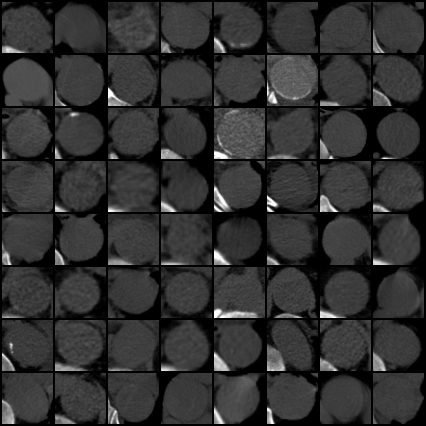

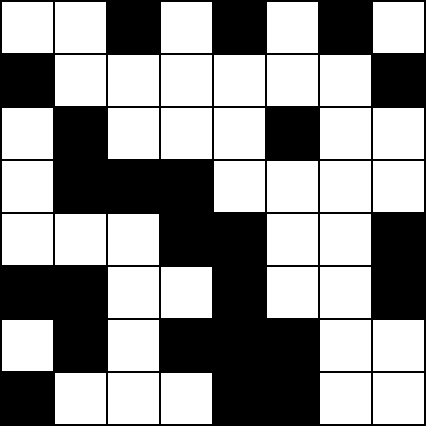

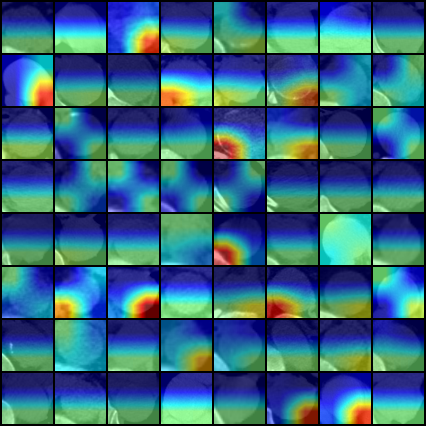

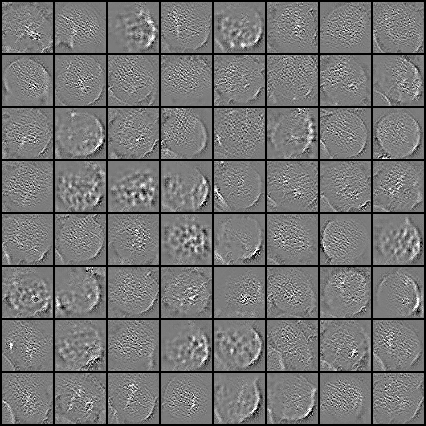

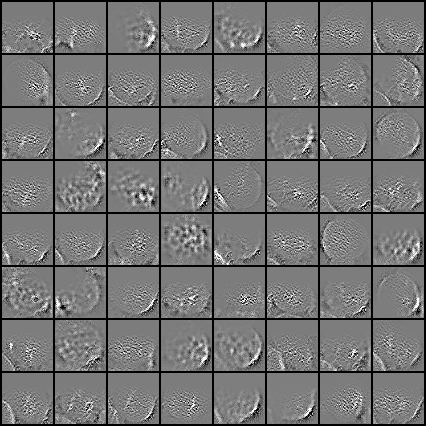

In [20]:
for imgs, true_categories in val_loader:
    imgs = imgs.to(device=device, dtype=torch.float32)
    true_categories = true_categories.to(device=device, dtype=torch.long)
    print(true_categories.view(8, 8))
    label_list = []
    cam_image_list = []
    gb_list = []
    cam_gb_list = []
    for i, img in enumerate(imgs):
        grayscale_cam = cam(img.unsqueeze(0), target_category=true_categories[i].item(),aug_smooth=True, eigen_smooth=True)
        if true_categories[i].item() == 0:
            label_list.append(torch.zeros(3,51,51,dtype=torch.uint8))
        elif true_categories[i].item() == 1:
            label_list.append(torch.ones(3,51,51,dtype=torch.uint8)*255)
        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(imgs[i].permute(1,2,0).cpu().numpy(), grayscale_cam, use_rgb=True)
        cam_image_list.append(torch.from_numpy(cam_image).permute(2,0,1))
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)
        gb = gb_model(img.unsqueeze(0), target_category=true_categories[i].item())
        cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
        cam_gb = cv2.cvtColor(deprocess_image(cam_mask * gb), cv2.COLOR_BGR2RGB)
        gb = cv2.cvtColor(deprocess_image(gb), cv2.COLOR_BGR2RGB)
        gb_list.append(torch.from_numpy(gb).permute(2,0,1))
        cam_gb_list.append(torch.from_numpy(cam_gb).permute(2,0,1))
    display(Image.fromarray((torchvision.utils.make_grid(imgs).permute(1,2,0).cpu().numpy()*255).astype(np.uint8)))
    display(Image.fromarray(torchvision.utils.make_grid(torch.stack(label_list)).permute(1,2,0).numpy()))
    display(Image.fromarray(torchvision.utils.make_grid(torch.stack(cam_image_list)).permute(1,2,0).numpy()))
    display(Image.fromarray(torchvision.utils.make_grid(torch.stack(gb_list)).permute(1,2,0).numpy()))
    display(Image.fromarray(torchvision.utils.make_grid(torch.stack(cam_gb_list)).permute(1,2,0).numpy()))
    break

In [ ]:
for imgs, true_categories in val_loader:
    imgs = imgs.to(device=device, dtype=torch.float32)
    true_categories = true_categories.to(device=device, dtype=torch.long)
    print(true_categories.view(8, 8))
    grayscale_cams = cam(input_tensor=imgs, target_category=true_categories, aug_smooth=True, eigen_smooth=True)
    visualization_list = []
    for i, grayscale_cam in enumerate(grayscale_cams):
        visualization = torch.from_numpy(show_cam_on_image(imgs[i].permute(1,2,0).cpu().numpy(), grayscale_cam)).permute(2,0,1)
        visualization_list.append(visualization)
    display(Image.fromarray(torchvision.utils.make_grid(torch.stack(visualization_list)).permute(1,2,0).numpy()))
    display(Image.fromarray((torchvision.utils.make_grid(imgs).permute(1,2,0).cpu().numpy()*255).astype(np.uint8)))
    break

In [ ]:
for imgs, true_categories in val_loader:
    imgs = imgs.to(device=device, dtype=torch.float32)
    true_categories = true_categories.to(device=device, dtype=torch.long)
    print(true_categories.view(16, 8))
    cam_image_list = []
    for i, img in enumerate(imgs):
        grayscale_cam = cam(input_img=img.unsqueeze(0), target_category=true_categories[i].item())
        cam_img = torch.from_numpy(show_cam_on_image(imgs[i].permute(1,2,0).cpu().numpy(), grayscale_cam)).permute(2,0,1)
        visualization_list.append(visualization)
    display(Image.fromarray(torchvision.utils.make_grid(torch.stack(visualization_list)).permute(1,2,0).numpy()))
    display(Image.fromarray((torchvision.utils.make_grid(imgs).permute(1,2,0).cpu().numpy()*255).astype(np.uint8)))
    break

In [ ]:
ori_img = Image.open('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/1/liuhongfu-J-57-200_j_0089.png')
tensor_img = transform(ori_img).unsqueeze(0)
tensor_label = torch.tensor([[1]], dtype=torch.long)
print(tensor_img.shape, tensor_label.shape)

In [ ]:
grayscale_cam = cam(input_img=tensor_img, target_category=1)
grayscale_cam = grayscale_cam[0, :]

In [ ]:
visualization = show_cam_on_image(tensor_img.squeeze(0).permute(1,2,0).numpy(), grayscale_cam)

In [ ]:
display(Image.fromarray(visualization))

In [ ]:
img = Image.open('111.png')
img = transform(img).unsqueeze(0).to(device=device)
img.requires_grad_()
net.zero_grad()
pred_cate = net(img)
print(f'pred_cate:{pred_cate.item()}')
target = torch.tensor([[0]], dtype=torch.float32).to(device=device, dtype=torch.float32)
loss = F.binary_cross_entropy_with_logits(pred_cate, target)
print(f'loss:{loss.item()}')
loss.backward()
grad = img.grad.data.squeeze(0).permute(1, 2, 0).squeeze(2)

In [ ]:
img_grad = torch.abs(grad)
img_grad = (img_grad / img_grad.max() * 255).type(torch.uint8)
img_grad = Image.fromarray(img_grad.cpu().numpy())
display(img_grad)

In [ ]:
input_path='/nfs3-p1/zsxm/dataset/aorta_classify/0/'
error_0_list = []
for f in os.listdir(input_path):
    img = Image.open(os.path.join(input_path, f))
    img = transform(img).unsqueeze(0).to(device=device)
    with torch.no_grad():
        pred_cate = net(img)
        if pred_cate.item() > 0:
            print(f)
            error_0_list.append(f)
            
print(f'len of error 0:{len(error_0_list)}')

In [ ]:
input_path='/nfs3-p1/zsxm/dataset/aorta_classify/1/'
error_1_list = []
for f in os.listdir(input_path):
    img = Image.open(os.path.join(input_path, f))
    img = transform(img).unsqueeze(0).to(device=device)
    with torch.no_grad():
        pred_cate = net(img)
        if pred_cate.item() < 0:
            print(f)
            error_1_list.append(f)
            
print(f'len of error 1:{len(error_1_list)}')